<a href="https://colab.research.google.com/github/Sebukpor/multi-cancer/blob/main/multi_cancer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import rc
from pylab import rcParams
import random

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

sns.set(style='whitegrid', palette='muted', font_scale=1.4)
rcParams['figure.figsize'] = 14, 8

# Setting seeds for reproducibility
SEED = 42

def set_seed(seed):
    tf.random.set_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(SEED)


In [ ]:
def list_folders(directory):
    try:
        # List all files and directories in the given directory
        items = os.listdir(directory)
        # Filter out directories only
        folders = [item for item in items if os.path.isdir(os.path.join(directory, item))]
        return folders
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return []

# Replace with your dataset directory path
dataset_directory = '/kaggle/input/cancer'
folders = list_folders(dataset_directory)
print(f"Folders in '{dataset_directory}': {folders}")


Folders in '/kaggle/input/cancer': ['val', 'test', 'train']


In [ ]:
input_path = '/kaggle/input/cancer'

# List all files and directories in the input path
for _set in ['train', 'val', 'test']:
    set_path = os.path.join(input_path, _set)
    print(f"Contents of {_set} directory: {os.listdir(set_path)}")

Contents of train directory: ['lymph_fl', 'colon_bnt', 'brain_tumor', 'cervix_koc', 'colon_aca', 'lymph_cll', 'kidney_tumor', 'all_pro', 'cervix_dyk', 'oral_scc', 'all_benign', 'kidney_normal', 'all_early', 'lymph_mcl', 'lung_aca', 'lung_bnt', 'breast_benign', 'oral_normal', 'lung_scc', 'all_pre', 'brain_glioma', 'cervix_pab', 'cervix_sfi', 'breast_malignant', 'brain_menin', 'cervix_mep']
Contents of val directory: ['lymph_fl', 'colon_bnt', 'brain_tumor', 'cervix_koc', 'colon_aca', 'lymph_cll', 'kidney_tumor', 'all_pro', 'cervix_dyk', 'oral_scc', 'all_benign', 'kidney_normal', 'all_early', 'lymph_mcl', 'lung_aca', 'lung_bnt', 'breast_benign', 'oral_normal', 'lung_scc', 'all_pre', 'brain_glioma', 'cervix_pab', 'cervix_sfi', 'breast_malignant', 'brain_menin', 'cervix_mep']
Contents of test directory: ['lymph_fl', 'colon_bnt', 'brain_tumor', 'cervix_koc', 'colon_aca', 'lymph_cll', 'kidney_tumor', 'all_pro', 'cervix_dyk', 'oral_scc', 'all_benign', 'kidney_normal', 'all_early', 'lymph_mcl',

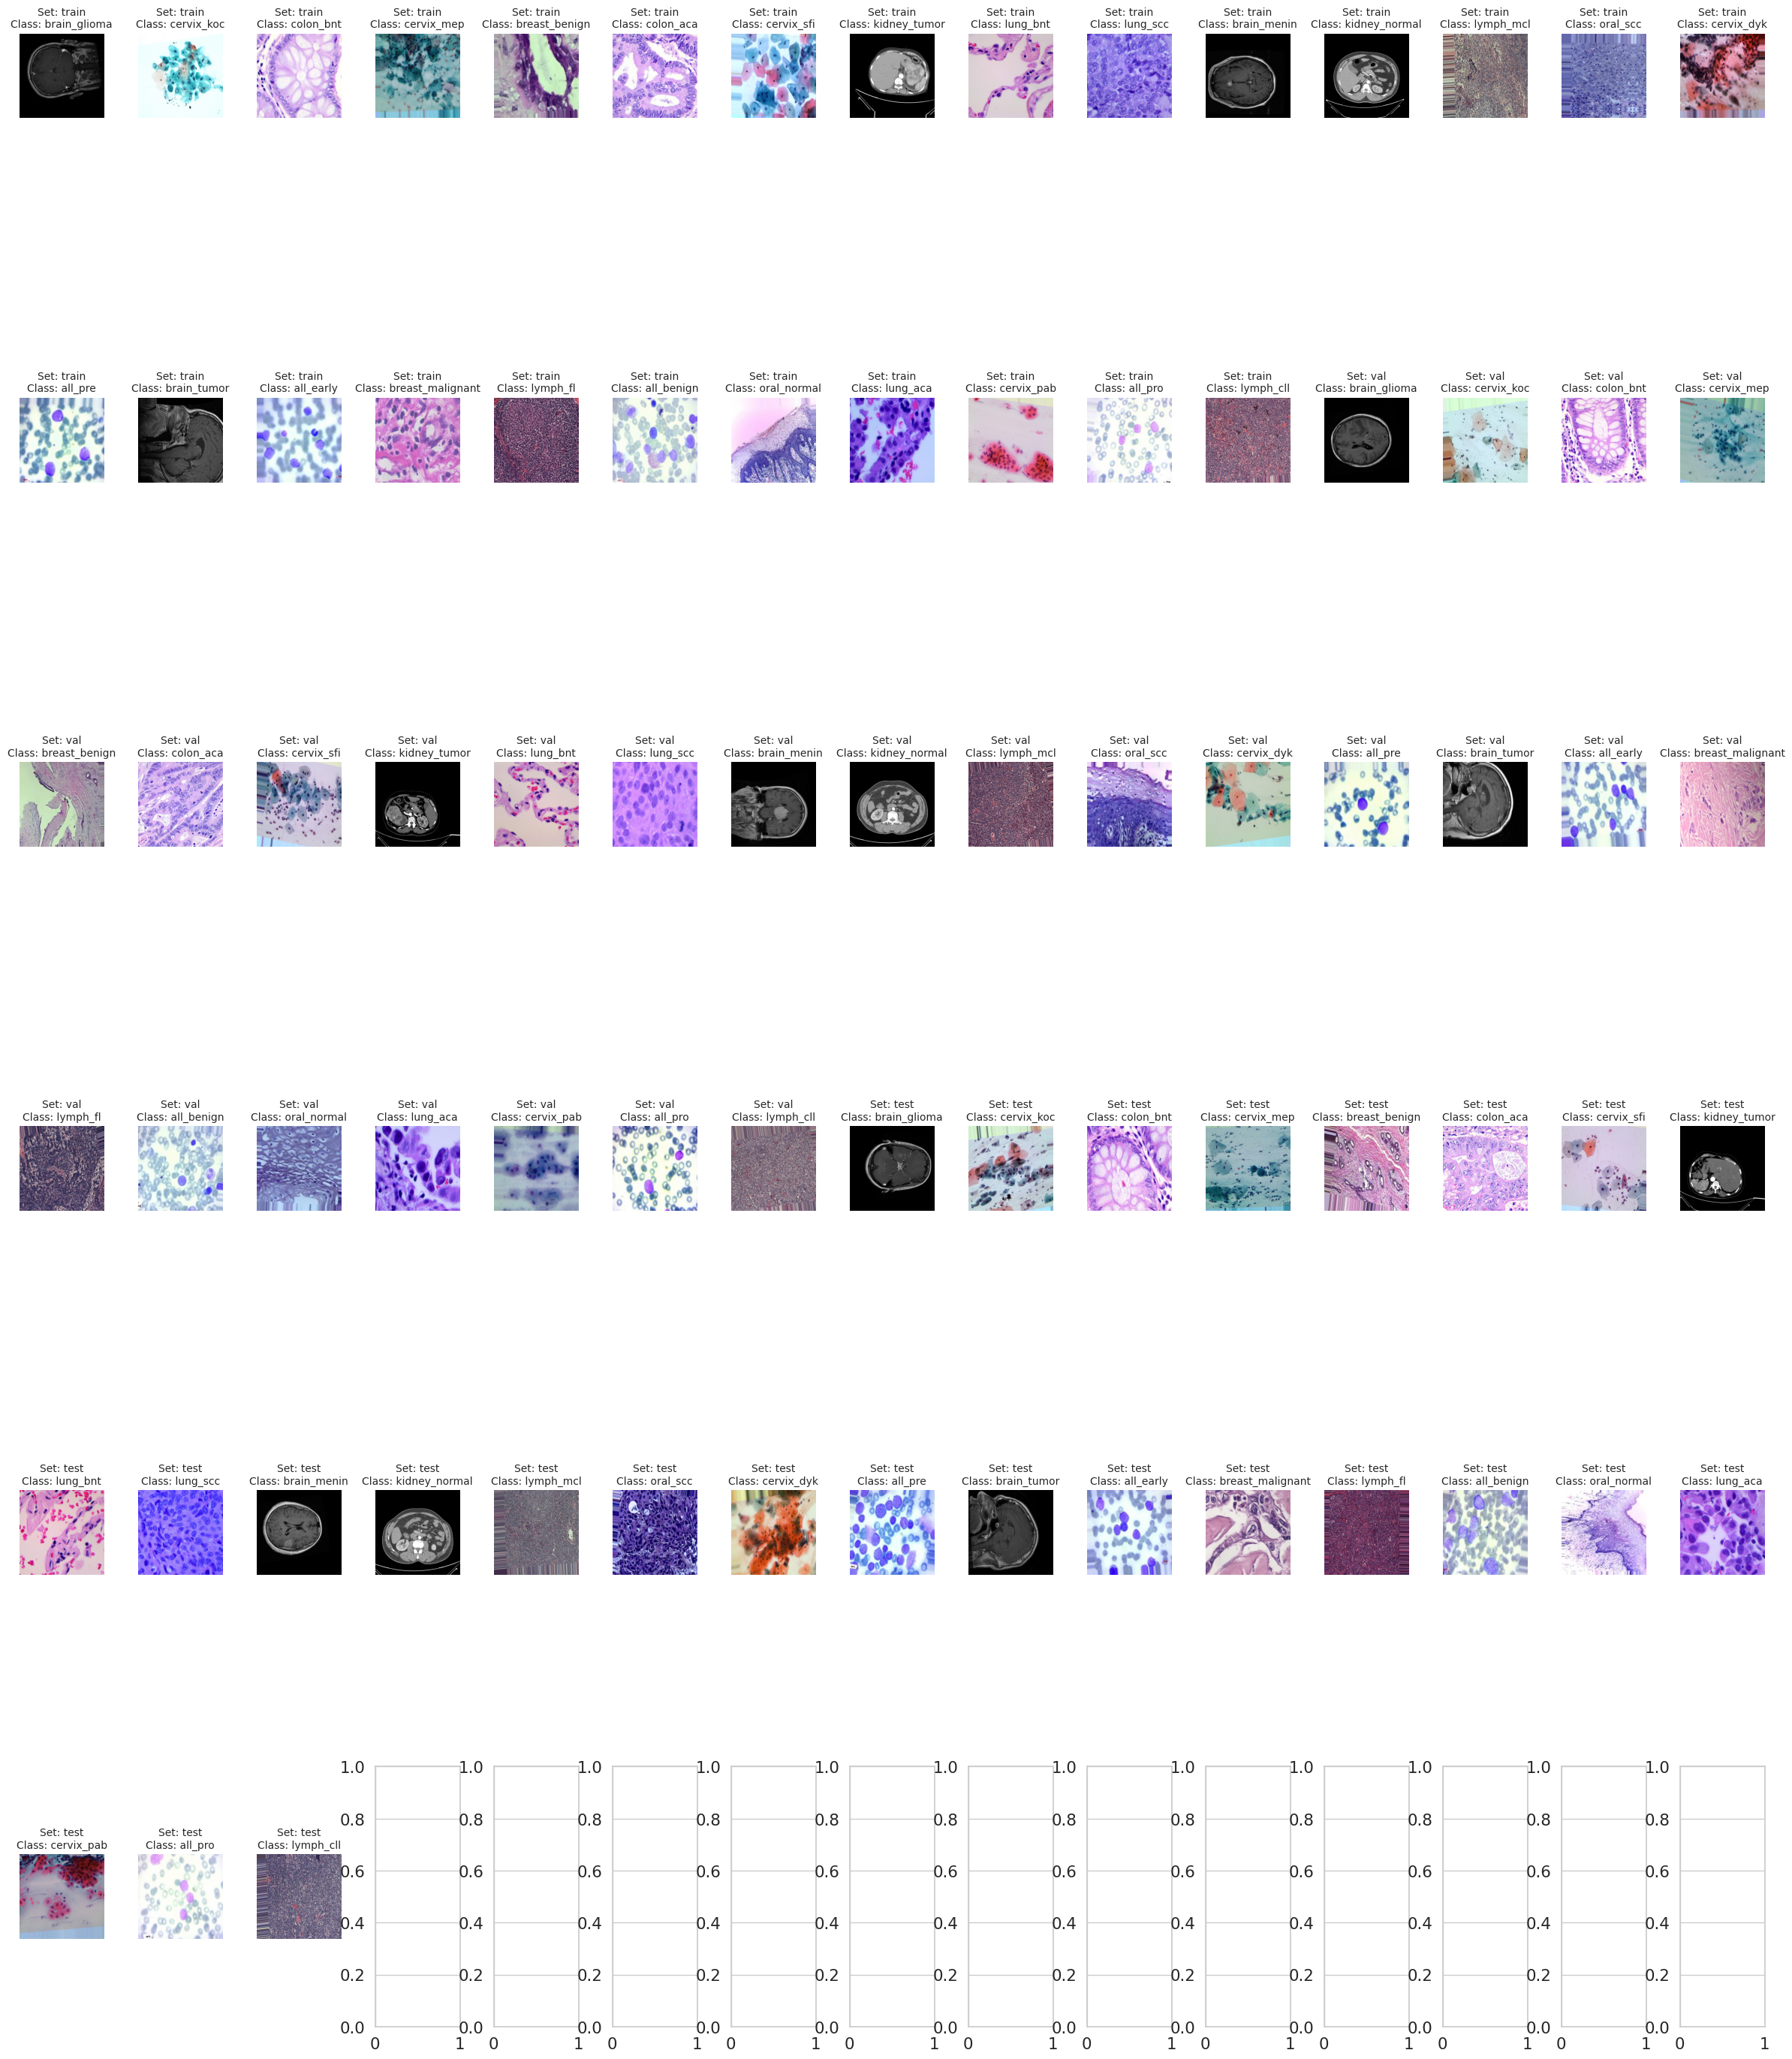

In [ ]:
# Define the root directory for your dataset
input_path = '/kaggle/input/cancer'

# Define the classes you want to display images from
classes = ['brain_glioma', 'cervix_koc', 'colon_bnt', 'cervix_mep', 'breast_benign', 'colon_aca', 'cervix_sfi',
           'kidney_tumor', 'lung_bnt', 'lung_scc', 'brain_menin', 'kidney_normal', 'lymph_mcl', 'oral_scc',
           'cervix_dyk', 'all_pre', 'brain_tumor', 'all_early', 'breast_malignant', 'lymph_fl', 'all_benign',
           'oral_normal', 'lung_aca', 'cervix_pab', 'all_pro', 'lymph_cll']

# Number of images to display for each class
num_images_to_show = 2

# Number of classes
num_classes = len(classes)

# Define the number of columns for the plot grid
num_cols = 5
num_rows = (num_classes + num_cols - 1) // num_cols  # Compute the number of rows needed

# Create a grid for plotting images with a larger figure size for better visibility
fig, ax = plt.subplots(num_rows, num_cols * 3, figsize=(30, num_rows * 6))  # Larger figure size for better visibility
ax = ax.ravel()

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Loop over the sets (train, val, test) and plot images
for i, _set in enumerate(['train', 'val', 'test']):
    set_path = os.path.join(input_path, _set)

    for j, class_name in enumerate(classes):
        class_dir = os.path.join(set_path, class_name)

        if os.path.exists(class_dir):
            # Get a list of images in the class directory
            class_images = os.listdir(class_dir)

            # Display the first image of the class if available
            if class_images:
                image_path = os.path.join(class_dir, class_images[0])
                idx = j + i * num_classes
                if idx < len(ax):
                    ax[idx].imshow(plt.imread(image_path), cmap='gray')
                    ax[idx].set_title(f'Set: {_set}\nClass: {class_name}', fontsize=10)
                    ax[idx].axis('off')
                else:
                    print(f"Index {idx} is out of bounds for the axes array.")
            else:
                idx = j + i * num_classes
                if idx < len(ax):
                    ax[idx].text(0.5, 0.5, 'No Image', horizontalalignment='center',
                                  verticalalignment='center', fontsize=12)
                    ax[idx].set_title(f'Set: {_set}\nClass: {class_name}', fontsize=10)
                    ax[idx].axis('off')
                else:
                    print(f"Index {idx} is out of bounds for the axes array.")
        else:
            idx = j + i * num_classes
            if idx < len(ax):
                ax[idx].text(0.5, 0.5, 'No Dir', horizontalalignment='center',
                              verticalalignment='center', fontsize=12)
                ax[idx].set_title(f'Set: {_set}\nClass: {class_name}', fontsize=10)
                ax[idx].axis('off')
            else:
                print(f"Index {idx} is out of bounds for the axes array.")

# Show the final plot
plt.show()


In [ ]:
# Define the root directory for your dataset
input_path = '/kaggle/input/cancer'

# Define the classes you want to report
classes = ['brain_glioma', 'cervix_koc', 'colon_bnt', 'cervix_mep', 'breast_benign', 'colon_aca', 'cervix_sfi',
           'kidney_tumor', 'lung_bnt', 'lung_scc', 'brain_menin', 'kidney_normal', 'lymph_mcl', 'oral_scc',
           'cervix_dyk', 'all_pre', 'brain_tumor', 'all_early', 'breast_malignant', 'lymph_fl', 'all_benign',
           'oral_normal', 'lung_aca', 'cervix_pab', 'all_pro', 'lymph_cll']

# Distribution of our datasets
for _set in ['train', 'val', 'test']:
    print(f"Set: {_set}")
    for class_name in classes:
        class_dir = os.path.join(input_path, _set, class_name)
        if os.path.exists(class_dir):
            n_images = len(os.listdir(class_dir))
        else:
            n_images = 0
        print(f"{class_name} images: {n_images}")
    print()  # Print a blank line for better readability between sets


Set: train
brain_glioma images: 4000
cervix_koc images: 4000
colon_bnt images: 4000
cervix_mep images: 4000
breast_benign images: 4000
colon_aca images: 4000
cervix_sfi images: 4000
kidney_tumor images: 4000
lung_bnt images: 4000
lung_scc images: 4000
brain_menin images: 4000
kidney_normal images: 4000
lymph_mcl images: 4000
oral_scc images: 4000
cervix_dyk images: 4000
all_pre images: 4000
brain_tumor images: 4000
all_early images: 4000
breast_malignant images: 4000
lymph_fl images: 4000
all_benign images: 4000
oral_normal images: 4000
lung_aca images: 4000
cervix_pab images: 4000
all_pro images: 4000
lymph_cll images: 4000

Set: val
brain_glioma images: 500
cervix_koc images: 500
colon_bnt images: 500
cervix_mep images: 500
breast_benign images: 500
colon_aca images: 500
cervix_sfi images: 500
kidney_tumor images: 500
lung_bnt images: 500
lung_scc images: 500
brain_menin images: 500
kidney_normal images: 500
lymph_mcl images: 500
oral_scc images: 500
cervix_dyk images: 500
all_pre im

In [ ]:
# Hyperparameters
img_dims = 224
batch_size = 32

In [ ]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

# Ensure proper path concatenation with a '/'
train_data_gen = image_gen.flow_from_directory(
    batch_size=batch_size,
    directory=os.path.join(input_path, 'train'),  # Use os.path.join to handle path properly
    shuffle=True,
    target_size=(img_dims, img_dims)
)


Found 104000 images belonging to 26 classes.


In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=os.path.join(input_path, 'train'),
                                               shuffle=True,
                                               target_size=(img_dims,img_dims))

Found 104000 images belonging to 26 classes.


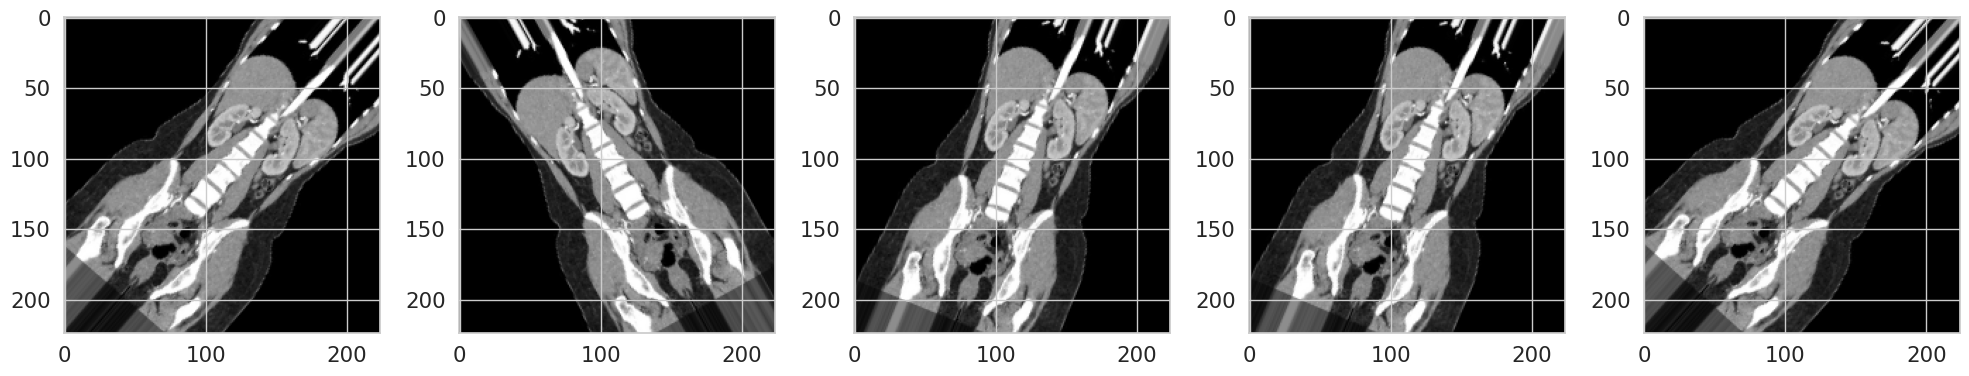

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=os.path.join(input_path,'train'),
                                               shuffle=True,
                                               target_size=(img_dims,img_dims))

Found 104000 images belonging to 26 classes.


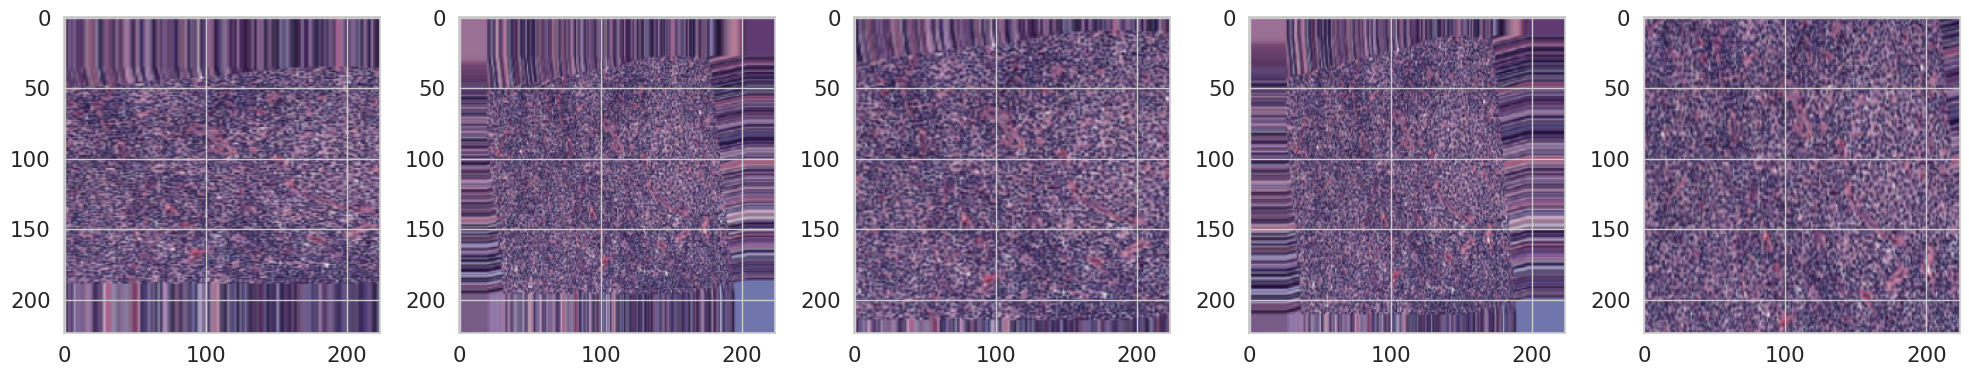

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [ ]:
image_gen_train = ImageDataGenerator(
rescale=1./255,
rotation_range=45,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest')



train_gen = image_gen_train.flow_from_directory(
directory=os.path.join(input_path,'train'),
target_size=(img_dims, img_dims),
batch_size=batch_size,
class_mode='binary',
shuffle=True)



Found 104000 images belonging to 26 classes.


In [ ]:
# Generate a batch of images
sample_batch = next(train_gen)
sample_images, sample_labels = sample_batch

# Check the shape of the images in the batch
print(f"Sample batch shape: {sample_images.shape}")



Sample batch shape: (32, 224, 224, 3)


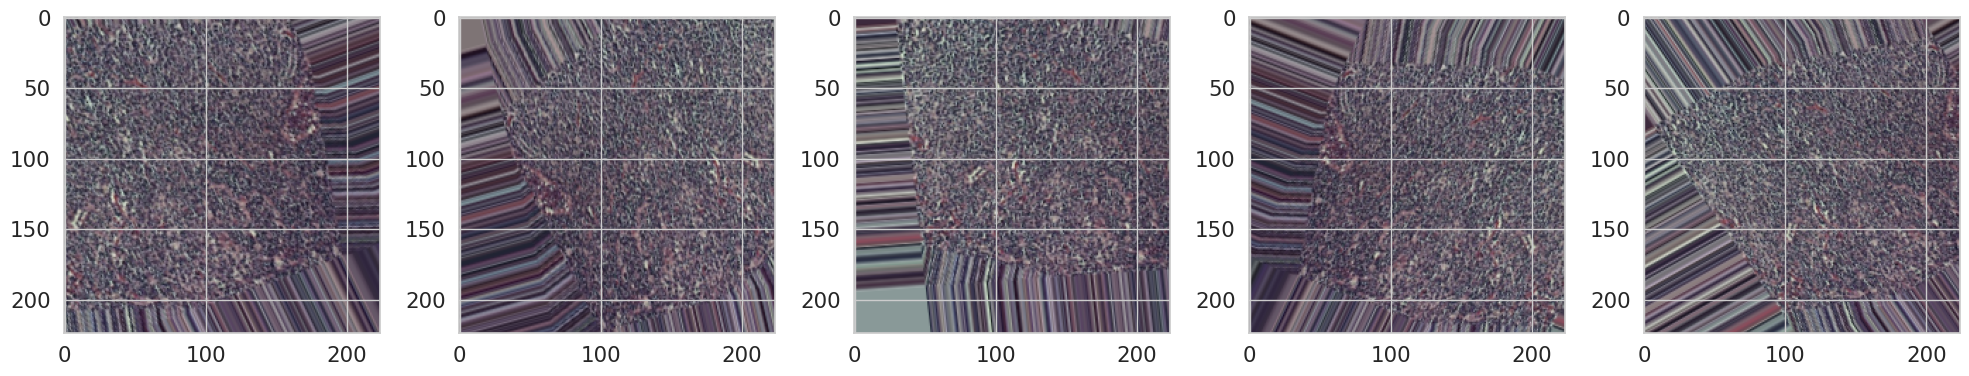

In [ ]:
augmented_images = [train_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Define the root directory for your dataset
input_path = '/kaggle/input/cancer'

# Define the dimensions for resizing images
img_dims = 224  # Replace with your desired dimensions

# Loop through all sets (train, val, test) and all classes
for _set in ['train', 'val', 'test']:
    print(f"Processing set: {_set}")
    for class_name in ['class1', 'class2']:  # Replace with your actual class names
        class_dir = os.path.join(input_path, _set, class_name)

        # Check if the directory exists
        if os.path.exists(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)

                # Read the image in RGB format
                img = cv2.imread(img_path)

                # Check if the image was loaded correctly
                if img is not None:
                    # Print original shape
                    print(f"Class: {class_name}, Image: {img_name}, Original shape: {img.shape}")

                    # Resize the image
                    img = cv2.resize(img, (img_dims, img_dims))
                    print(f"Class: {class_name}, Image: {img_name}, Shape after resize: {img.shape}")

                    # Normalize the image
                    img = img.astype('float32') / 255.0
                    print(f"Class: {class_name}, Image: {img_name}, Shape after normalization: {img.shape}")
                else:
                    print(f"Error loading image: {img_path}")

    print()  # Print a blank line for better readability between sets


Processing set: train

Processing set: val

Processing set: test



In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def process_data(img_dims, batch_size, input_path, SEED):
    # Update the number of classes based on the folder names
    num_classes = len(os.listdir(os.path.join(input_path, 'train')))

    # Data generators for training and testing
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.3,
        vertical_flip=True
    )
    train_gen = train_datagen.flow_from_directory(
        directory=os.path.join(input_path, 'train'),
        target_size=(img_dims, img_dims),
        batch_size=batch_size,
        class_mode='categorical',  # Updated for multi-class classification
        seed=SEED,
        shuffle=True
    )

    test_val_datagen = ImageDataGenerator(rescale=1./255)
    test_gen = test_val_datagen.flow_from_directory(
        directory=os.path.join(input_path, 'test'),
        target_size=(img_dims, img_dims),
        batch_size=batch_size,
        class_mode='categorical',  # Updated for multi-class classification
        seed=SEED,
        shuffle=False  # Generally, no shuffling in test data
    )

    return train_gen, test_gen


In [ ]:
# Example usage
SEED = 42
input_path = '/kaggle/input/cancer'  # Dataset path
img_dims = 224  # Image dimensions
batch_size = 32  # Batch size

train_gen, test_gen = process_data(img_dims, batch_size, input_path, SEED)

Found 104000 images belonging to 26 classes.
Found 13002 images belonging to 26 classes.


In [ ]:
# Get a batch of data from the test generator
images, labels = next(test_gen)  # Fetch one batch from the generator

# Print the shape of the images and labels in this batch
print(f'Images batch shape: {images.shape}')
print(f'Labels batch shape: {labels.shape}')


Images batch shape: (32, 224, 224, 3)
Labels batch shape: (32, 26)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Load the ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-tune the last few layers of ResNet50
for layer in base_model.layers[-35:]:
    layer.trainable = True

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Custom layer 1
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# Custom layer 2
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Custom layer 3
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Custom layer 4
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

# Output layer
output = Dense(26, activation='softmax')(x)

# Define the full model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model with an optimizer and loss function
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Learning rate scheduler callback
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 26,385,946 (100.65 MB)

 Trainable params: 26,328,986 (100.44 MB)

 Non-trainable params: 56,960 (222.50 KB)

In [ ]:
# Fit the model with the callbacks
hist = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    epochs=21,  # Adjust based on your need
    validation_data=test_gen,
    validation_steps=test_gen.samples // batch_size,
    callbacks=[lr_scheduler, early_stopping]  # Include lr_scheduler and checkpoint
)

# Save the model as an H5 file
model.save('my_cancer_classification_model.h5')



Epoch 1/21


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1726944546.553195     109 service.cc:145] XLA service 0x7b13140033c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726944546.553259     109 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1726944582.257258     109 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_10', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_4', 4 bytes spill stores, 12 bytes spill

3250/3250 ━━━━━━━━━━━━━━━━━━━━ 1995s 591ms/step - categorical_accuracy: 0.7480 - loss: 18.8397 - val_categorical_accuracy: 0.9383 - val_loss: 2.6009 - learning_rate: 1.0000e-04
Epoch 2/21


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3250/3250 ━━━━━━━━━━━━━━━━━━━━ 3s 771us/step - categorical_accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_categorical_accuracy: 0.8000 - val_loss: 2.6536 - learning_rate: 1.0000e-04
Epoch 3/21
3250/3250 ━━━━━━━━━━━━━━━━━━━━ 1417s 435ms/step - categorical_accuracy: 0.9428 - loss: 1.6846 - val_categorical_accuracy: 0.9621 - val_loss: 0.5063 - learning_rate: 1.0000e-04
Epoch 4/21
3250/3250 ━━━━━━━━━━━━━━━━━━━━ 0s 15us/step - categorical_accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_categorical_accuracy: 1.0000 - val_loss: 0.5258 - learning_rate: 1.0000e-04
Epoch 5/21
3250/3250 ━━━━━━━━━━━━━━━━━━━━ 1394s 428ms/step - categorical_accuracy: 0.9577 - loss: 0.4473 - val_categorical_accuracy: 0.9768 - val_loss: 0.2515 - learning_rate: 1.0000e-04
Epoch 6/21
3250/3250 ━━━━━━━━━━━━━━━━━━━━ 0s 58us/step - categorical_accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_categorical_accuracy: 1.0000 - val_loss: 0.1918 - learning_rate: 1.0000e-04
Epoch 7/21
3250/3250 ━━━━━━━━━━━━━━━━━━━━ 1404s 431ms/step - ca

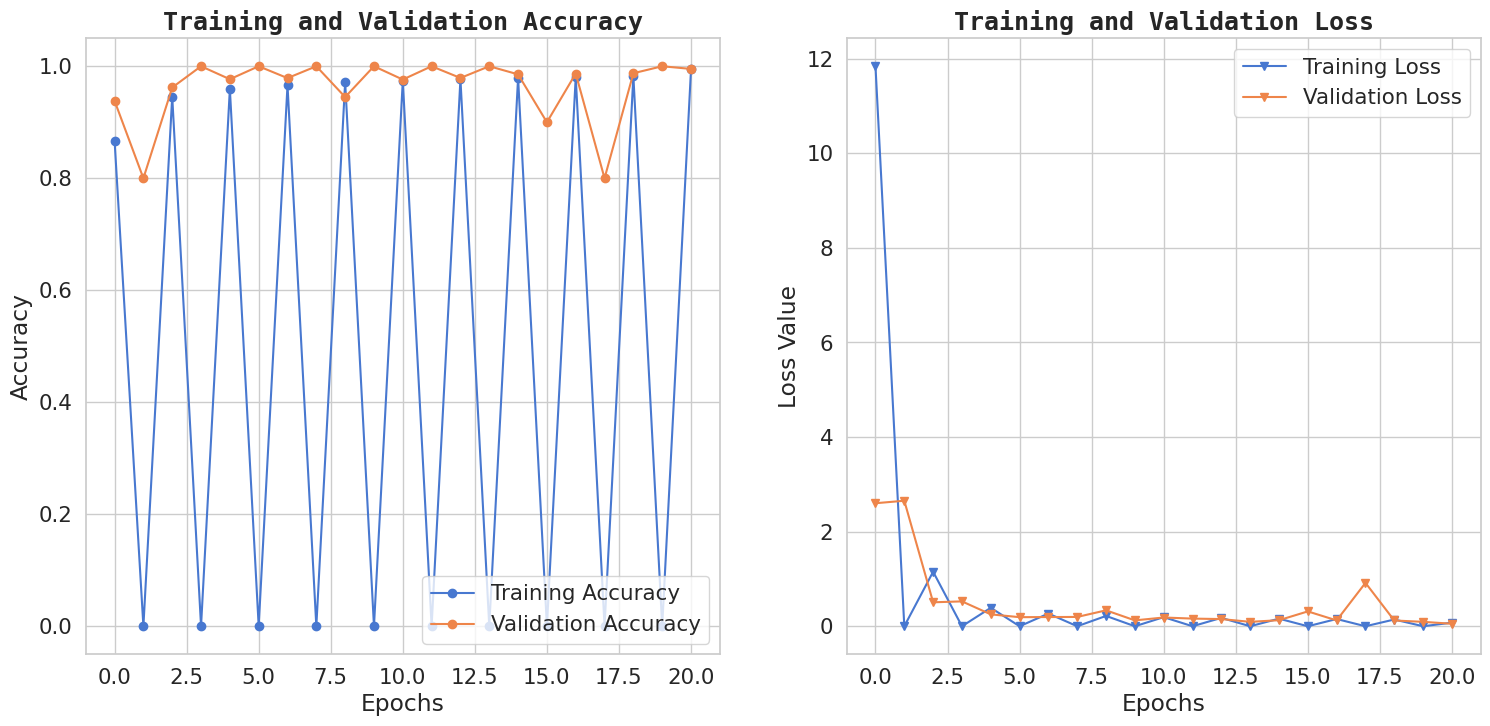

In [ ]:
# Extract accuracy and loss history
acc = hist.history['categorical_accuracy']
val_acc = hist.history['val_categorical_accuracy']  # Corrected key

loss = hist.history['loss']
val_loss = hist.history['val_loss']

# Adjust range to match the number of epochs dynamically
epochs_range = range(len(acc))

# Plot training & validation accuracy
plt.figure(figsize=(18, 8))

# Subplot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, '-o', label='Training Accuracy')
plt.plot(epochs_range, val_acc, '-o', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Training and Validation Accuracy', size=18, fontweight='bold', fontname='monospace')

# Subplot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, "-v", label='Training Loss')
plt.plot(epochs_range, val_loss, '-v', label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.title('Training and Validation Loss', size=18, fontweight='bold', fontname='monospace')

# Show the plots
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import numpy as np

# Make predictions and convert to class labels (argmax to get the index of the highest probability)
preds = np.argmax(model.predict(test_gen), axis=1)

# Use true labels directly since they are not one-hot encoded
y_true = test_gen.labels
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import numpy as np

# Get model predictions (these are probabilities)
preds_prob = model.predict(test_gen)

# Top-1 accuracy: Get the class with the highest probability (Top-1)
preds_top1 = np.argmax(preds_prob, axis=1)

# Top-5 accuracy: Check if the true class is among the top 5 predicted classes
top5_preds = np.argsort(preds_prob, axis=1)[:, -5:]  # Get the indices of the top 5 predictions for each sample
top5_correct = np.array([y_true[i] in top5_preds[i] for i in range(len(y_true))])

# Use true labels directly since they are not one-hot encoded
y_true = test_gen.labels

# Calculate Top-1 accuracy
top1_acc = accuracy_score(y_true, preds_top1) * 100

# Calculate Top-5 accuracy
top5_acc = np.mean(top5_correct) * 100

# Generate confusion matrix for multi-class classification (based on Top-1 predictions)
cm = confusion_matrix(y_true, preds_top1)

print('CONFUSION MATRIX ------------------')
print(cm)

# Calculate precision, recall, and F1-score for each class (based on Top-1 predictions)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, preds_top1, average='macro')  # 'macro' for multi-class average

print('\nTEST METRICS ----------------------')
print(f'Top-1 Accuracy: {top1_acc:.2f}%')
print(f'Top-5 Accuracy: {top5_acc:.2f}%')
print(f'Precision (macro avg): {precision:.2f}')
print(f'Recall (macro avg): {recall:.2f}')
print(f'F1-score (macro avg): {f1_score:.2f}')

# Train accuracy from the training history
print('\nTRAIN METRIC ----------------------')
print('Train acc: {:.2f}%'.format(np.round((hist.history['categorical_accuracy'][-1]) * 100, 2)))

# Calculate accuracy
acc = accuracy_score(y_true, preds) * 100

# Generate confusion matrix for multi-class classification
cm = confusion_matrix(y_true, preds)

print('CONFUSION MATRIX ------------------')
print(cm)

# Calculate precision, recall, and F1-score for each class
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, preds, average='macro')  # 'macro' for multi-class average

print('\nTEST METRICS ----------------------')
print(f'Accuracy: {acc:.2f}%')
print(f'Precision (macro avg): {precision:.2f}')
print(f'Recall (macro avg): {recall:.2f}')
print(f'F1-score (macro avg): {f1_score:.2f}')

# Train accuracy from the training history
print('\nTRAIN METRIC ----------------------')
print('Train acc: {:.2f}%'.format(np.round((hist.history['categorical_accuracy'][-1]) * 100, 2)))


407/407 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step
407/407 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step
CONFUSION MATRIX ------------------
[[500   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0 500   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0 500   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0 500   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0   0 500   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0   0   4 482  14   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 500   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 499   1   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  

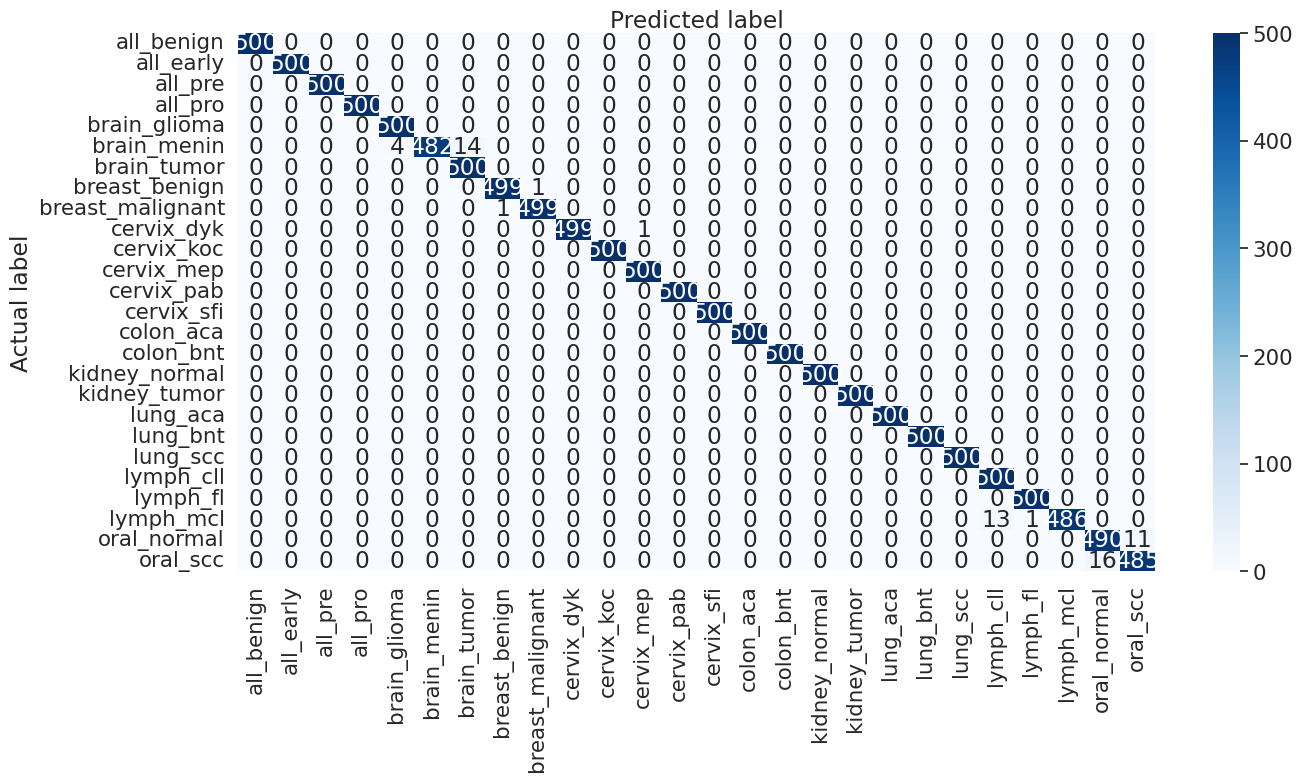

In [ ]:
class_names = ['all_benign', 'all_early', 'all_pre', 'all_pro', 'brain_glioma', 'brain_menin', 'brain_tumor',
               'breast_benign', 'breast_malignant', 'cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab',
               'cervix_sfi', 'colon_aca', 'colon_bnt', 'kidney_normal', 'kidney_tumor', 'lung_aca', 'lung_bnt',
               'lung_scc', 'lymph_cll', 'lymph_fl', 'lymph_mcl', 'oral_normal', 'oral_scc']


fig,ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks,class_names)
plt.yticks(tick_marks,class_names)

df_cm = pd.DataFrame(cm, index=class_names, columns=class_names, )
sns.heatmap(df_cm,annot=True,cmap="Blues",fmt="d")
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

In [ ]:
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image

# Define image dimensions and the path to the model
img_dims = 224  # This should match the input shape of your model (224, 224, 3)
model_path = '/kaggle/working/my_cancer_classification_model.h5'  # Update this with the path to your model

# Load your trained model
model = tf.keras.models.load_model(model_path)

# Define the class names (make sure they match the training classes)
class_names = ['all_benign', 'all_early', 'all_pre', 'all_pro', 'brain_glioma', 'brain_menin', 'brain_tumor',
               'breast_benign', 'breast_malignant', 'cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab',
               'cervix_sfi', 'colon_aca', 'colon_bnt', 'kidney_normal', 'kidney_tumor', 'lung_aca', 'lung_bnt',
               'lung_scc', 'lymph_cll', 'lymph_fl', 'lymph_mcl', 'oral_normal', 'oral_scc']


def prepare_image(img_path, img_dims):
    """ Preprocess the image to be compatible with the model input """
    img = image.load_img(img_path, target_size=(img_dims, img_dims))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image to [0, 1]
    return img_array

def make_prediction(img_path, model):
    """ Load image, preprocess, and predict the class """
    img_array = prepare_image(img_path, img_dims)

    # Make a prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]  # Get the predicted class index

    # Map the predicted index to the class name
    predicted_class_name = class_names[predicted_class]

    print(f'Predicted class: {predicted_class_name}')
    return predicted_class_name

# Example usage: Replace with the path to your image
img_path = '/kaggle/input/cancer/val/oral_scc/oral_scc_0005.jpg'  # Update with the actual image path
predicted_class = make_prediction(img_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class: oral_scc


In [ ]:
export_dir = 'saved_model/Pneumonia'
tf.saved_model.save(model, export_dir)

In [ ]:
import tensorflow as tf

export_dir = 'saved_model/Pneumonia'
model = tf.saved_model.load(export_dir)


In [ ]:
!pip install tensorflowjs --upgrade &> /dev/null

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [ ]:
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model --signature_name=serving_default --saved_model_tags=serve saved_model/Pneumonia/ tfjs_model/


In [ ]:
import shutil

# Define the source directory and destination zip file path
source_dir = '/kaggle/working/tfjs_model'
output_filename = '/kaggle/working/tfjs_model.zip'

# Zip the directory
shutil.make_archive(output_filename.replace('.zip', ''), 'zip', source_dir)

print(f"Directory {source_dir} has been zipped as {output_filename}")


Directory /kaggle/working/tfjs_model has been zipped as /kaggle/working/tfjs_model.zip
